In [26]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""
# !pip install scikit-learn
import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict



#Downloading the proper data
def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [27]:
# %pip install tensorflow
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes
# %pip install keras
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [28]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


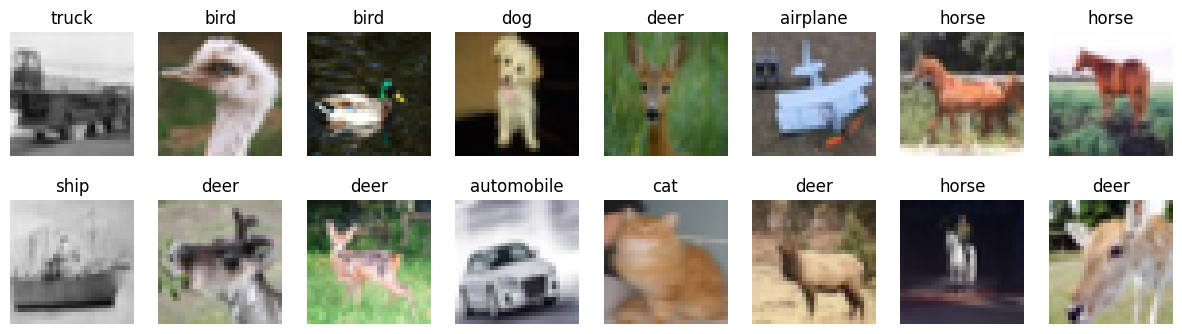

In [29]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [30]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [31]:
# import necessary building blocks
#Conv2D: "The Conv2D layer applies a set of convolutional filters to the input image, allowing the network to detect spatial patterns like edges and textures."
#MaxPooling2D: "The MaxPooling2D layer reduces the spatial dimensions of the feature maps by selecting the maximum value in each pooling window, helping to downsample the data and retain important features."
#Flatten: "The Flatten layer converts multi-dimensional feature maps into a one-dimensional vector, making them compatible with fully connected layers in the neural network."
#Dense: "The Dense layer is a fully connected layer where each neuron receives input from all neurons in the previous layer, allowing for high-level reasoning in the network."
#Activation: "The Activation layer applies a non-linear function (like ReLU or sigmoid) to introduce non-linearity and enable the network to learn complex patterns."
#Dropout: "The Dropout layer randomly deactivates a fraction of neurons during training, reducing overfitting by forcing the network to generalize better."
#BatchNormalization: "The BatchNormalization layer normalizes activations across a batch of data, accelerating training and improving stability by reducing internal covariate shift.
##Information also retrieved from ChatGPT

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU

In [32]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
  ##We build a model that has 3 convolutional blocks
  ##It returns a compiled Keras Sequential model ready for training
    model = Sequential()
    model.add(keras.Input(shape=(32,32,3))) #32x32 RGB images
    model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10))

    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax"))

    return model

In [33]:
model = make_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,802 (288.29 KB)

 Trainable params: 73,610 (287.54 KB)

 Non-trainable params: 192 (768.00 B)

In [34]:
###Model Training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 20

#We run small amounts of epochs, since the time loading each one is a bit longer that expected


K.clear_session()  # clear default graph

model = make_model()  # define our model

#We should use the early stopping callback in order to avoid unnecessary training
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', #Stop training if there is no improvement in validation accuracy
    patience=10,  #N. of epochs before stopping
    restore_best_weights=True, #Restoring model
    verbose=1
)


lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', #Validation loss of monitor
    factor=0.5, #Half reduction of LR
    patience=3, #3 epochs wait before reducing LR
    min_lr=1e-6, #Minimum limit of LR
    verbose=1
)

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
history = model.fit(
    x_train, y_train, #prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler], #Early stopping and LR scheduler
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights(".weights.h5")

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 121ms/step - accuracy: 0.2969 - loss: 1.9684 - val_accuracy: 0.4041 - val_loss: 1.6514 - learning_rate: 0.0050
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 109ms/step - accuracy: 0.4889 - loss: 1.4247 - val_accuracy: 0.4734 - val_loss: 1.5907 - learning_rate: 0.0050
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 115ms/step - accuracy: 0.5579 - loss: 1.2465 - val_accuracy: 0.5406 - val_loss: 1.2794 - learning_rate: 0.0050
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 109ms/step - accuracy: 0.6006 - loss: 1.1417 - val_accuracy: 0.5307 - val_loss: 1.6311 - learning_rate: 0.0050
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 119ms/step - accuracy: 0.6292 - loss: 1.0509 - val_accuracy: 0.6082 - val_loss: 1.1323 - learning_rate: 0.0050
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 108ms/step - accuracy: 0.6553 - loss: 0.9915 - val_accuracy: 0.5935 - val_loss: 1.1457 - learning_rate: 0.0050
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - accuracy: 0.6

The epoch run was executed in approximately 25 minutes, which is longer than expected. Thus, since each run was 75 seconds on average, we had to reduce the number of epochs to 20

In [35]:
# load weights from file (can call without model.fit)
model.load_weights(".weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


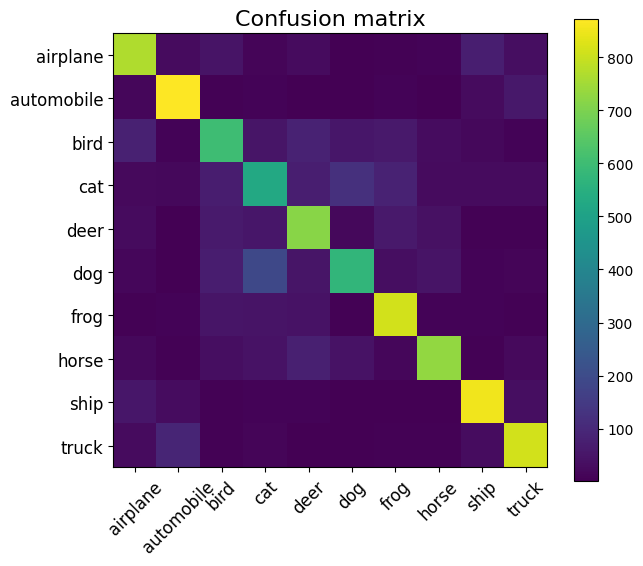

Test accuracy: 0.7262


In [36]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

The model achieved a total final accuracy of 72.62%, as indicated above. This means that it can predict effectively the data, although the training was executed in more restricted ways, due to the time loading. If the number of epochs was permitted to be larger, then the test accuracy  would be higher as well. Sometimes, the model can get confused from the shapes and the colors of the data. For instance, it can be seen in the diagonal matrix that the dog and the cat category have a darker color than the other categories, indicating the difficulty to distinguish.

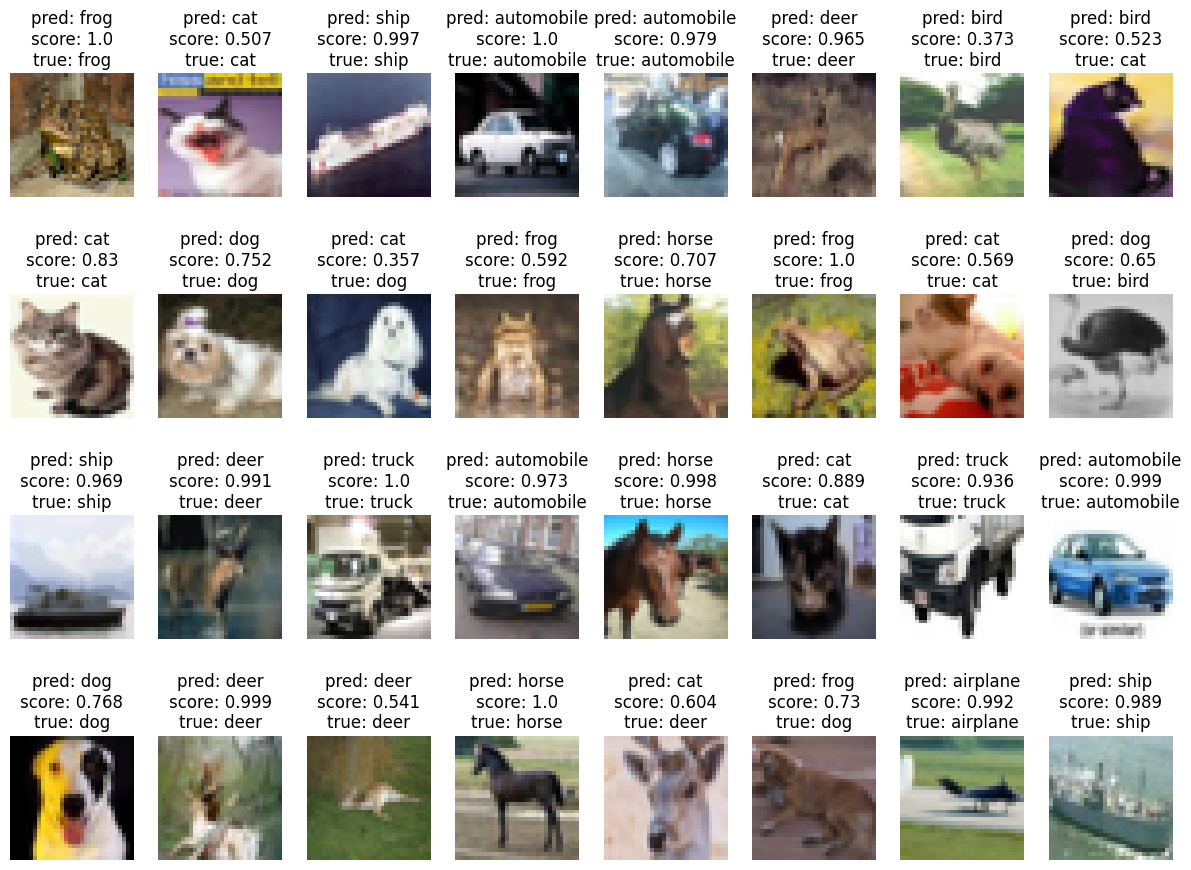

In [37]:
# inspect preditions
cols = 8
rows = 4
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

We can see that the predictions are pretty accurate, although there are few examples where the model struggles to properly identify the correct category. The lower scores are also caused due to the limitation in the model training.

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.



